In [1]:
%matplotlib inline
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import seaborn as sns
import scipy.stats as st
from theano import shared

plt.style.use('seaborn-darkgrid')

In [2]:
def invlogit(x):
    return np.exp(x) / (1 + np.exp(x))

def scale_x(x, k, x0, y0):
    return k*(x-x0) + np.log(y0/(1-y0)) 

x0 = 3.5; y0 = 0.8; k = 1.6

In [3]:
n = 4000
coeff = 1.

predictors = np.random.uniform(0, 10, 100)
predictors_shared = shared(predictors)

x = scale_x(predictors, k, 4, y0)
outcomes = np.random.binomial(1, invlogit(x))

In [4]:
predictors_out_of_sample = np.random.uniform(2.2,4,30)
x = scale_x(predictors_out_of_sample, k, x0, y0)

outcomes_out_of_sample = np.random.binomial(1, invlogit(x))

In [5]:
with pm.Model() as model:
    pia = pm.Normal('pia', mu=x0, sigma=1)
    x = scale_x(predictors_shared, k, pia, y0)
    outcome = pm.Bernoulli('outcome', logit_p = x, observed=outcomes)
    trace = pm.sample(500)
    mp = pm.find_MAP(include_transformed=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [pia]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 12 seconds.


/Users/nicolle_nordmann/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:88: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


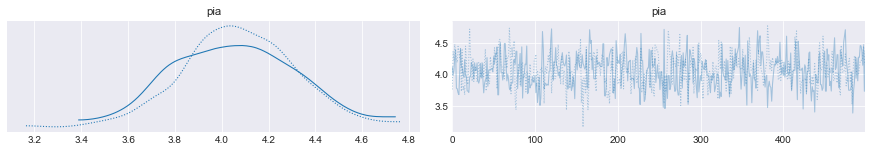

In [6]:
pm.traceplot(trace);

In [7]:
pia_update = np.mean(trace['pia'])

In [8]:
predictors_shared.set_value(predictors_out_of_sample)

In [9]:
ppc = pm.sample_posterior_predictive(trace, model=model, samples=100)

/Users/nicolle_nordmann/anaconda3/lib/python3.8/site-packages/pymc3/sampling.py:1617: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


In [10]:
from matplotlib.ticker import StrMethodFormatter
sns.set()
blue, green, red, purple, gold, teal = sns.color_palette(n_colors=6)
pct_formatter = StrMethodFormatter('{x:.1%}')

In [11]:
(ppc['outcome'] == 1).sum(axis=0)

array([71, 48, 40, 47, 26, 19, 81, 15, 31, 72, 83, 69, 62, 70, 80, 80, 43,
       25, 45, 14, 21, 45, 23, 39, 32, 40, 59, 24, 52, 46])

In [12]:
(ppc['outcome'] == 0).sum(axis=0)

array([29, 52, 60, 53, 74, 81, 19, 85, 69, 28, 17, 31, 38, 30, 20, 20, 57,
       75, 55, 86, 79, 55, 77, 61, 68, 60, 41, 76, 48, 54])

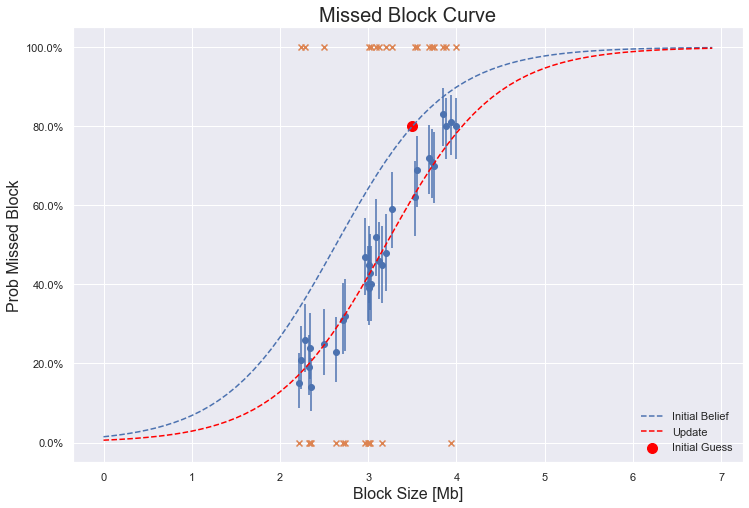

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

β = st.beta((ppc['outcome'] == 1).sum(axis=0), (ppc['outcome'] == 0).sum(axis=0))

# estimated probability
ax.scatter(x=predictors_out_of_sample, y=β.mean())

# error bars on the estimate
plt.vlines(predictors_out_of_sample, *β.interval(0.95))

# actual outcomes
ax.scatter(x=predictors_out_of_sample, y=outcomes_out_of_sample, marker='x')

# True probabilities
x_pia = np.arange(0,7,0.1)
x_pia_belief = scale_x(x_pia, k, x0, y0)
x_pia_update = scale_x(x_pia, k, pia_update, y0)
ax.scatter(x=x0, y=y0, color='red',s=100, label='Initial Guess')
ax.plot(x_pia, invlogit(x_pia_belief), linestyle='--', label='Initial Belief')
ax.plot(x_pia, invlogit(x_pia_update), linestyle='--', label='Update',color='red')
ax.yaxis.set_major_formatter(pct_formatter);
ax.set_xlabel('Block Size [Mb]', fontsize=16)
ax.set_ylabel('Prob Missed Block', fontsize=16);
ax.set_title("Missed Block Curve", fontsize=20);
ax.legend(loc='lower right')